In [2]:
import logging

import cvxportfolio as cp
import pandas as pd
import pyfolio as pf

from optimizer.alpha import MomentumAlpha
from optimizer.blp import get_index_weights, get_index_members_ret, get_index_ret
from optimizer.opt import IndexRebalOpt
from optimizer.risk import HistCovRiskModel

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
# config
index = 'SHSZ300 Index'  # CSI 300
sim_start_date = pd.Timestamp(2021, 1, 1)
sim_end_date = pd.Timestamp(2022, 9, 16)

In [5]:
# load index data
idx_weight = get_index_weights(index)
returns = get_index_members_ret(index)
returns['cash'] = 0

idx_weight

index_member,000001 CH Equity,000002 CH Equity,000063 CH Equity,000066 CH Equity,000069 CH Equity,000100 CH Equity,000157 CH Equity,000166 CH Equity,000301 CH Equity,000333 CH Equity,...,688036 CH Equity,688065 CH Equity,688111 CH Equity,688126 CH Equity,688169 CH Equity,688363 CH Equity,688396 CH Equity,688561 CH Equity,688599 CH Equity,688981 CH Equity
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.011714,0.013595,0.006036,0.000000,0.002284,0.004424,0.002549,0.003322,0.000000,0.020769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.011950,0.013405,0.006234,0.000000,0.002279,0.004510,0.002542,0.003334,0.000000,0.020286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.011919,0.013229,0.006283,0.000000,0.002294,0.004488,0.002481,0.003321,0.000000,0.019993,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-07,0.011879,0.013228,0.006216,0.000000,0.002296,0.004413,0.002472,0.003320,0.000000,0.020128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-08,0.011674,0.013348,0.006135,0.000000,0.002260,0.004611,0.002452,0.003281,0.000000,0.020443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12,0.006438,0.006444,0.004110,0.000927,0.001172,0.003044,0.001556,0.002008,0.001936,0.014163,...,0.000824,0.000591,0.001797,0.001153,0.000747,0.000707,0.001441,0.000710,0.004098,0.004065
2022-09-13,0.006526,0.006427,0.004136,0.000924,0.001140,0.003024,0.001547,0.001990,0.001889,0.014371,...,0.000833,0.000599,0.001854,0.001150,0.000751,0.000706,0.001438,0.000712,0.004044,0.004068
2022-09-14,0.006488,0.006403,0.004193,0.000936,0.001146,0.003021,0.001557,0.001989,0.001851,0.014388,...,0.000843,0.000664,0.002005,0.001159,0.000749,0.000714,0.001445,0.000714,0.004074,0.004091


In [6]:
# build alpha forecast
alpha = MomentumAlpha(returns, 250)

# build risk model
gamma_risk = 5.0 
risk_model = HistCovRiskModel(returns, 250 * 5)  # "or past 5 years daily data to calculate Cov matrix"

# build transaction cost model
gamma_trade = 1.0  # turnover rate can be controlled here
tcost_model = cp.TcostModel(half_spread=6e-4)  # CN-A market charge is around 6 bps

# build optimizer policy
ir_policy = IndexRebalOpt(alpha, [gamma_risk * risk_model, gamma_trade * tcost_model], idx_weight, tracking_error=0.03)

In [7]:
# build initial portfolio
# "Suppose we initially have a basket of $10 million CSI300 underlying stocks, with equal weights."
init_port = (idx_weight.loc[sim_start_date] > 0) * 10e6 / 300
init_port['cash'] = 0

In [13]:
# simulation
market_sim = cp.MarketSimulator(returns, [], cash_key='cash')
result = market_sim.run_backtest(init_port, start_time=sim_start_date, end_time=sim_end_date, policy=ir_policy)
result.summary()

Start date,2021-01-01
End date,2022-09-15
Total months,21
,Backtest
Annual return,-2.832%
Cumulative returns,-4.947%
Annual volatility,18.603%
Sharpe ratio,-0.06
Calmar ratio,-0.12
Stability,0.27
Max drawdown,-24.607%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.61,2021-02-15,2022-04-26,NaT,NaN
1,4.91,2021-01-25,2021-01-29,2021-02-09,12
2,2.93,2021-01-12,2021-01-19,2021-01-25,10
3,1.35,2021-01-07,2021-01-11,2021-01-12,4
4,0.0,2021-02-10,2021-02-11,2021-02-15,4


Stress Events,mean,min,max
New Normal,-0.00%,-4.76%,4.30%


Top 10 long positions of all time,max
600519 CH Equity,6.43%
601318 CH Equity,4.72%
300750 CH Equity,4.26%
600036 CH Equity,3.78%
000858 CH Equity,3.30%
000333 CH Equity,2.59%
601012 CH Equity,2.37%
600276 CH Equity,2.12%
601166 CH Equity,1.93%
601888 CH Equity,1.78%


Top 10 short positions of all time,max


Top 10 positions of all time,max
600519 CH Equity,6.43%
601318 CH Equity,4.72%
300750 CH Equity,4.26%
600036 CH Equity,3.78%
000858 CH Equity,3.30%
000333 CH Equity,2.59%
601012 CH Equity,2.37%
600276 CH Equity,2.12%
601166 CH Equity,1.93%
601888 CH Equity,1.78%


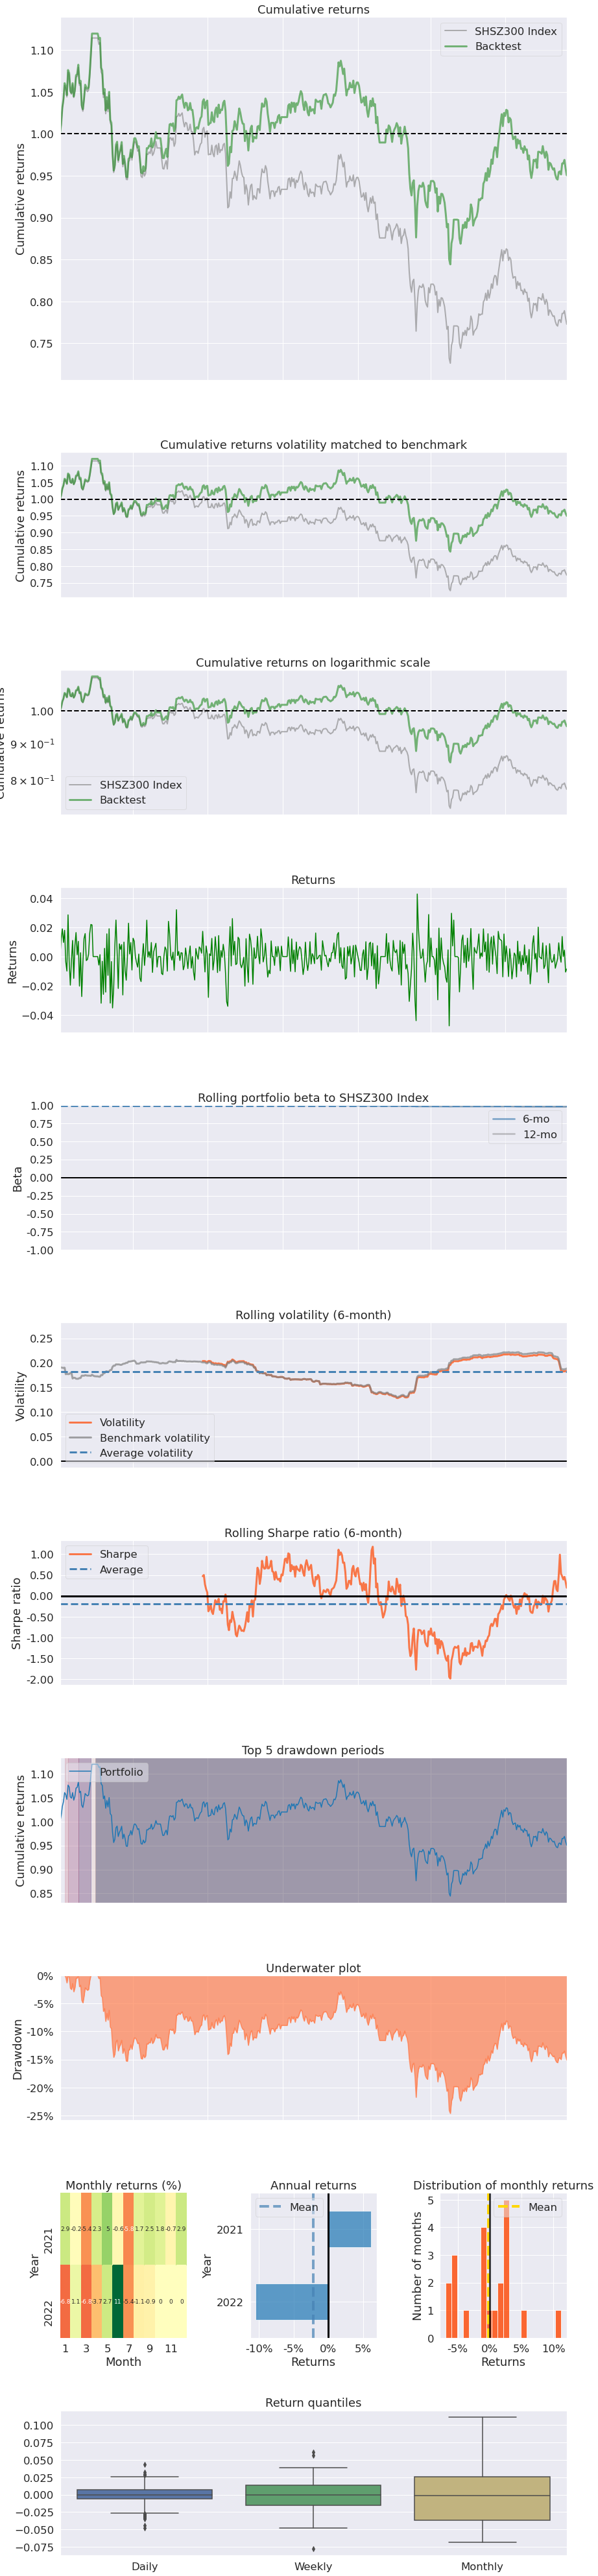

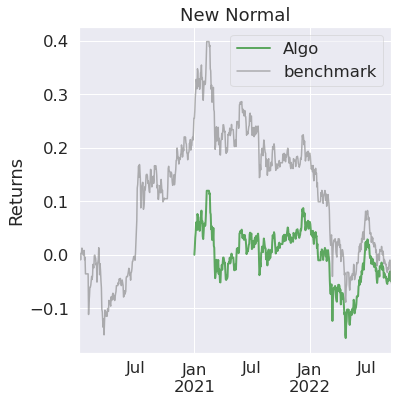

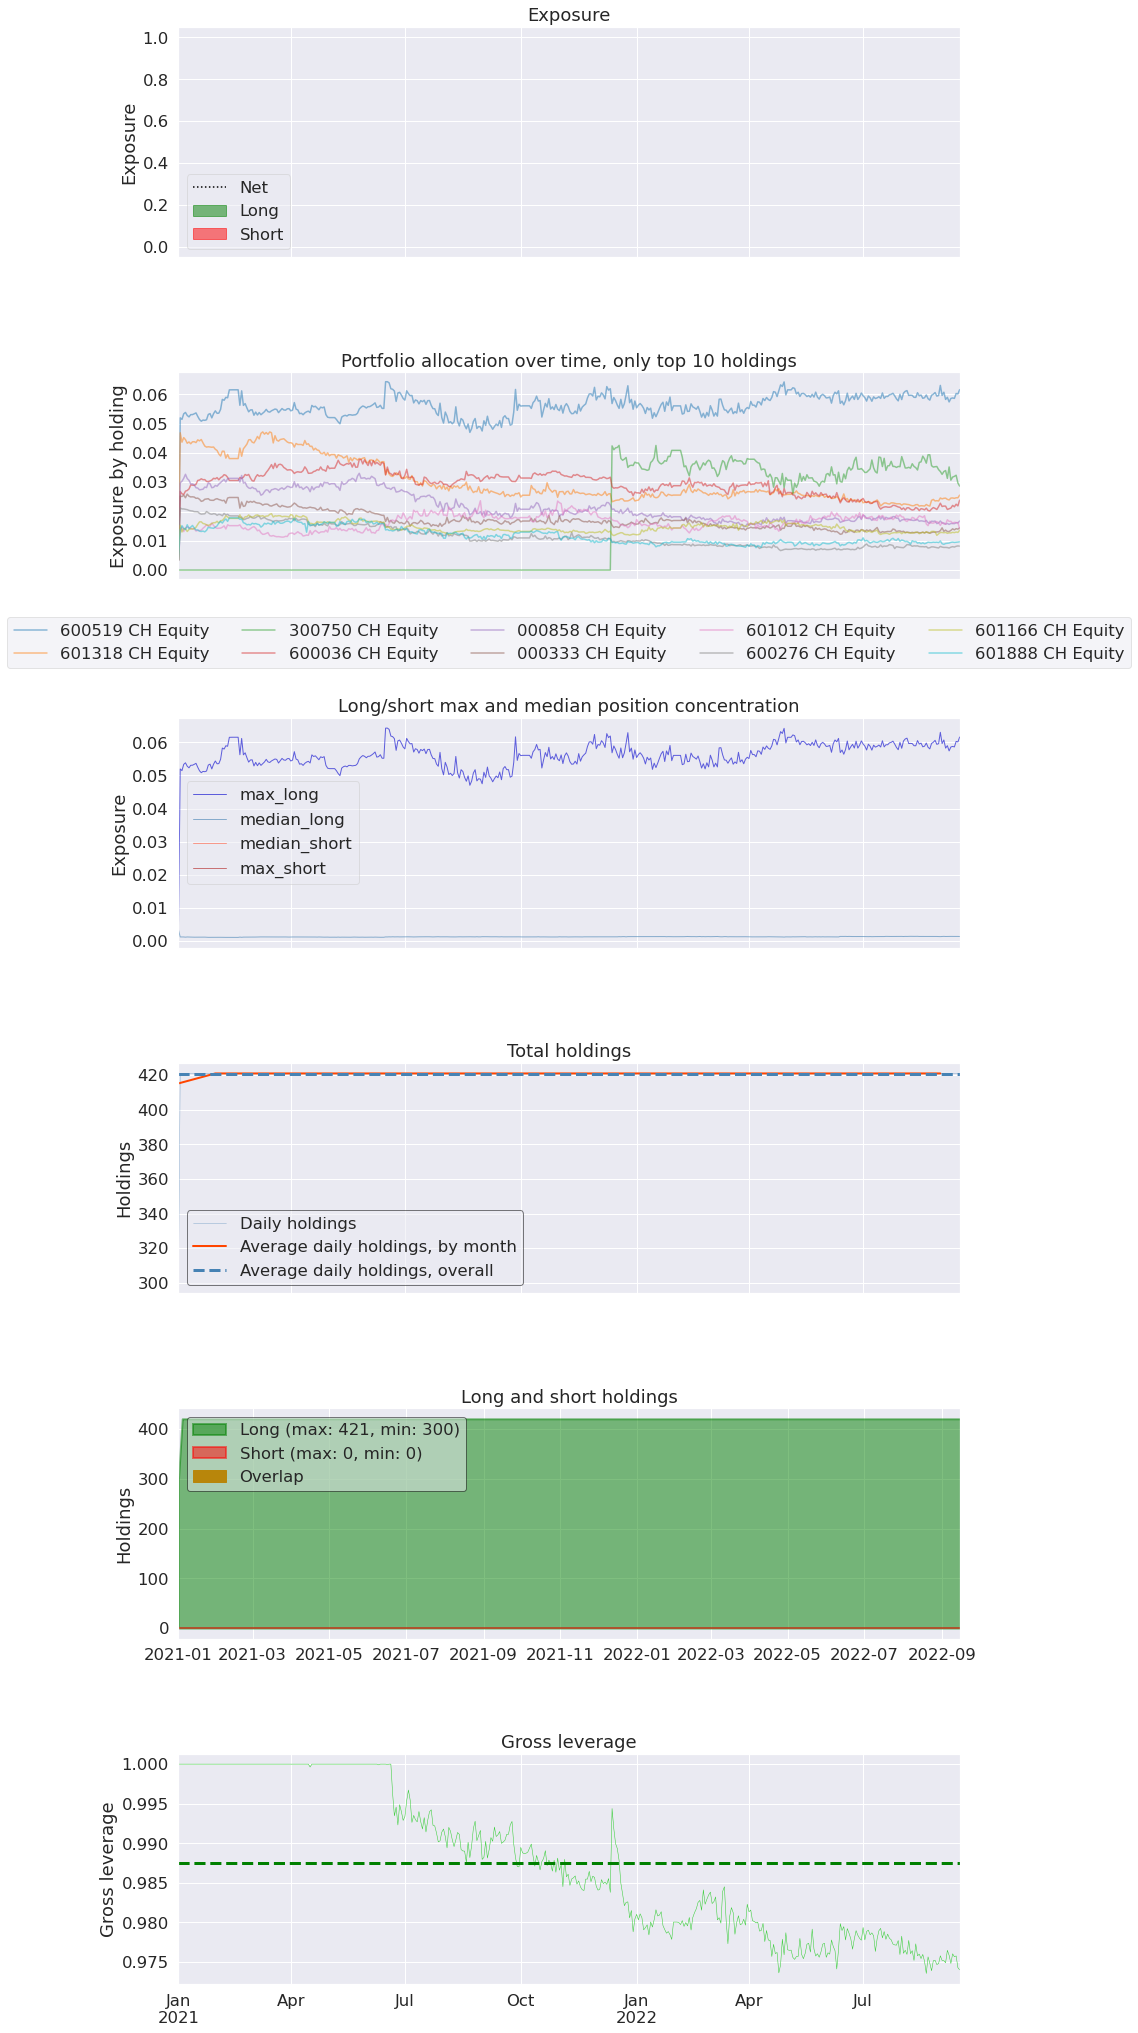

In [11]:
# analytics
benchmark_rets = get_index_ret(index)
pf.create_full_tear_sheet(result.returns, positions=result.h, benchmark_rets=benchmark_rets[index])